In [74]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [75]:
# Load precipitation data (Assuming data in monthly format)
data = pd.read_csv('data\csv\Monthly.v3.1-19930101-20231231.csv', parse_dates=['time'], index_col='time')
precipitation = data['rfe'].fillna(0)

In [76]:
# Function to calculate SPI
def spi(ds, thresh):
    #Rolling Mean
    ds_ma = ds.rolling(window=thresh, min_periods=1, center=False).mean()

    # Replace zeros in rolling mean with a small value to avoid log issues
    epsilon = 1e-6  # Small value to substitute for zeros
    ds_ma_safe = ds_ma.replace(0, epsilon)
    
    #Nutural log of M. A.
    ds_In = np.log(ds_ma_safe)

    ds_mu = ds_ma.mean()

    #summation of log of M. A.
    ds_sum = ds_In.sum()

    #computing for gamma distribution
    n = len(ds_In)
    A = np.log(ds_mu) - (ds_sum/n)
    alpha = (1 / (4 * A) ) * (1 + (1 + (4 * A) / 3) ** 0.5)
    beta = ds_mu/alpha

    #gamm distribution (CDF)
    gamma = st.gamma.cdf(ds_ma, a=alpha, scale=beta)

    #SPI (Inverse of CDF)
    norm_spi = st.norm.ppf(gamma, loc=0, scale=1)

    return pd.Series(norm_spi, index=ds.index)

In [77]:
spi_values = spi(precipitation, 3)

c:\Users\IITA-GISguest2\Desktop\GIS\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [78]:
def classify_drought(spi_values):
    drought_classification = pd.Series('No drought', index=spi_values.index)
    drought_classification[spi_values <= -1.0] = 'Drought'
    drought_classification[spi_values <= -1.5] = 'Severe drought'
    drought_classification[spi_values <= -2.0] = 'Extreme drought'
    return drought_classification
droughts = classify_drought(spi_values)

In [79]:
# Function to get drought periods and durations
def identify_drought_periods(drought_classification):
    drought_periods = []
    current_drought = None
    start_date = None

    for date, status in drought_classification.items():
        if status == 'No drought':
            if current_drought:
                drought_periods.append((start_date, date - pd.Timedelta(days=1), current_drought))
                current_drought = None
            continue
        
        if not current_drought:
            start_date = date
            current_drought = status

    if current_drought:
        drought_periods.append((start_date, date, current_drought))
    
    return drought_periods

# Get drought periods and their durations
drought_periods = identify_drought_periods(droughts)

# Convert to DataFrame for better readability
drought_periods_df = pd.DataFrame(drought_periods, columns=['Start Date', 'End Date', 'Drought Type'])
# Ensure the 'Start Date' and 'End Date' columns are in datetime format
drought_periods_df['Start Date'] = pd.to_datetime(drought_periods_df['Start Date'])
drought_periods_df['End Date'] = pd.to_datetime(drought_periods_df['End Date'])

# Now, calculate the duration
drought_periods_df['Duration (Days)'] = (drought_periods_df['End Date'] - drought_periods_df['Start Date']).dt.days

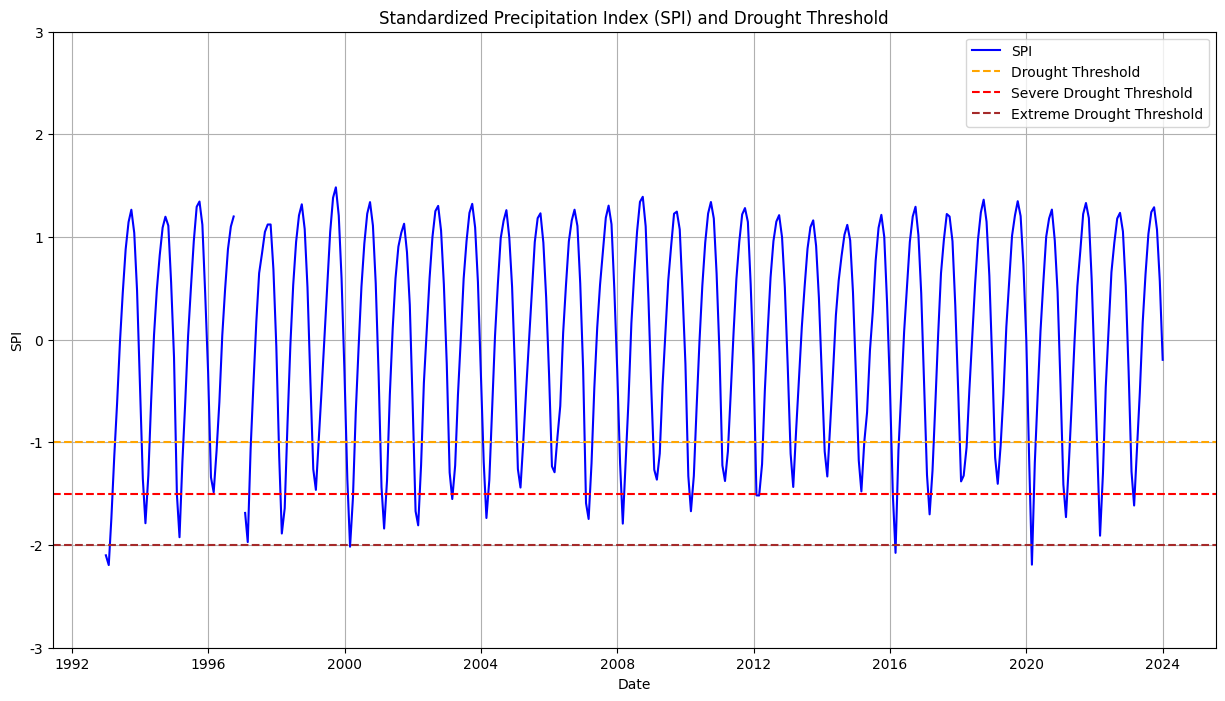

In [80]:
# Plot SPI values
plt.figure(figsize=(15, 8))
plt.plot(spi_values.index, spi_values, label="SPI", color='blue')
plt.axhline(y=-1.0, color='orange', linestyle='--', label="Drought Threshold")
plt.axhline(y=-1.5, color='red', linestyle='--', label="Severe Drought Threshold")
plt.axhline(y=-2.0, color='brown', linestyle='--', label="Extreme Drought Threshold")
plt.title('Standardized Precipitation Index (SPI) and Drought Threshold')
plt.xlabel('Date')
plt.yticks(range(-3,4), range(-3,4))
plt.ylabel('SPI')
plt.legend()
plt.grid(True)
plt.show()


In [81]:
# Display drought periods and durations
print(drought_periods_df)


   Start Date   End Date     Drought Type  Duration (Days)
0  1992-12-31 1993-04-29  Extreme drought              119
1  1994-01-31 1994-04-29          Drought               88
2  1995-01-31 1995-04-29   Severe drought               88
3  1996-01-31 1996-04-29          Drought               89
4  1996-10-31 1997-04-29  Extreme drought              180
5  1998-01-31 1998-04-29          Drought               88
6  1999-01-31 1999-03-30          Drought               58
7  2000-01-31 2000-04-29          Drought               89
8  2001-01-31 2001-04-29          Drought               88
9  2002-01-31 2002-04-29   Severe drought               88
10 2003-01-31 2003-04-29          Drought               88
11 2004-01-31 2004-04-29          Drought               89
12 2005-01-31 2005-03-30          Drought               58
13 2006-01-31 2006-03-30          Drought               58
14 2007-01-31 2007-04-29   Severe drought               88
15 2008-01-31 2008-04-29          Drought               